<a href="https://colab.research.google.com/github/rrankawat/pytorch-cnn/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key characteristics of CIFAR-10:
* Size: 60,000 images.
* Dimensions: Each image is 32 pixels by 32 pixels.
* Color: Images are in color, with RGB channels.
* Classes: 10 distinct categories of objects.
* Data Split: A standard configuration uses 50,000 images for training and 10,000 images for testing.
### Examples of the 10 classes:
* Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, and Truck.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##### Transform, Data Loading & Converting To Batches

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:09<00:00, 17.2MB/s]


##### CNN Model

In [4]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # -> 16x32x32
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # -> 64x32x32
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # -> 64x32x32
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # -> 128x32x32
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128*2*2, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)  # 32 -> 16

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)  # 16 -> 8

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)  # 8 -> 4

        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)  # 4 -> 2

        # Flatten
        x = x.view(-1, 128*2*2)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

##### Random Seeds and Model Instance

In [5]:
torch.manual_seed(41)
model = CIFARConvNet()

##### Loss & Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### Time Function

In [7]:
def totalTime(start_time):
  current_time = time.time()
  total_time = (current_time - start_time) / 60
  return round(total_time, 2)

##### Model Training & Testing

In [8]:
# Variables to track things
epochs = 50
train_losses = []
train_correct = []
test_losses = []
test_correct = []

In [9]:
# -------------------
# Training function
# -------------------
def train(epoch, model, train_loader, criterion, optimizer):
  model.train()

  trn_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    trn_corr += (predicted == y_train).sum()

    # Back-propagation & Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Print out results
  print(f"Epoch: {epoch + 1} \tLoss: {loss.item():.6f}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

In [10]:
# -------------------
# Test function
# -------------------
def test(model, test_loader, criterion, optimizer):
  model.eval()
  tst_corr = 0

  with torch.no_grad():
    for X_test, y_test in test_loader:
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

In [11]:
# Training Run Epochs
start_time = time.time()

for epoch in range(epochs):
  train(epoch, model, train_loader, criterion, optimizer)

print(f'Time taken: {totalTime(start_time)} minutes!')

Epoch: 1 	Loss: 1.195599
Epoch: 2 	Loss: 0.975666
Epoch: 3 	Loss: 0.948501
Epoch: 4 	Loss: 0.918531
Epoch: 5 	Loss: 0.655955
Epoch: 6 	Loss: 0.893644
Epoch: 7 	Loss: 0.681926
Epoch: 8 	Loss: 0.745354
Epoch: 9 	Loss: 0.773261
Epoch: 10 	Loss: 0.652870
Epoch: 11 	Loss: 0.711567
Epoch: 12 	Loss: 0.706313
Epoch: 13 	Loss: 0.763364
Epoch: 14 	Loss: 0.648116
Epoch: 15 	Loss: 0.494015
Epoch: 16 	Loss: 0.578338
Epoch: 17 	Loss: 0.471046
Epoch: 18 	Loss: 0.541835
Epoch: 19 	Loss: 0.574449
Epoch: 20 	Loss: 0.500323
Epoch: 21 	Loss: 0.450180
Epoch: 22 	Loss: 0.511091
Epoch: 23 	Loss: 0.450359
Epoch: 24 	Loss: 0.640619
Epoch: 25 	Loss: 0.593535
Epoch: 26 	Loss: 0.460444
Epoch: 27 	Loss: 0.547366
Epoch: 28 	Loss: 0.582985
Epoch: 29 	Loss: 0.388861
Epoch: 30 	Loss: 0.648751
Epoch: 31 	Loss: 0.505554
Epoch: 32 	Loss: 0.499743
Epoch: 33 	Loss: 0.575758
Epoch: 34 	Loss: 0.535739
Epoch: 35 	Loss: 0.531483
Epoch: 36 	Loss: 0.461115
Epoch: 37 	Loss: 0.586998
Epoch: 38 	Loss: 0.480437
Epoch: 39 	Loss: 0.59

In [12]:
# Testing
start_time = time.time()

test(model, test_loader, criterion, optimizer)

print(f'Time taken: {totalTime(start_time)} minutes!')

Time taken: 0.11 minutes!


##### Plots

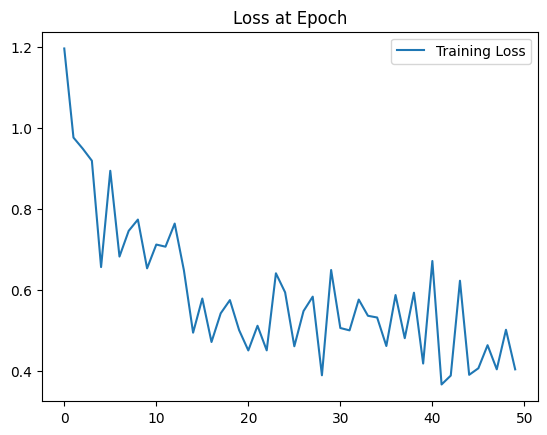

In [13]:
# -----------------------------
# Training loss at each Epoch
# -----------------------------
plt.plot([loss.detach().numpy() for loss in train_losses], label='Training Loss')
plt.title('Loss at Epoch')
plt.legend()

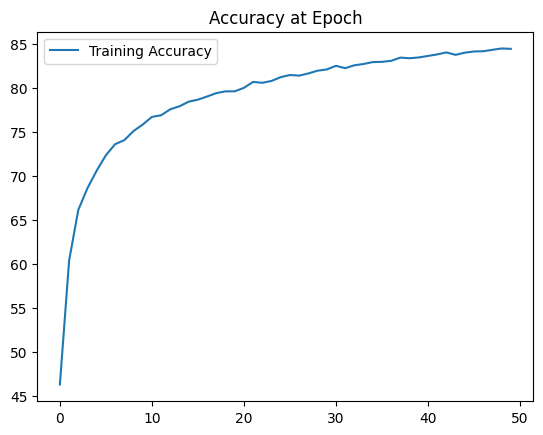

In [14]:
# --------------------------------------------
# Training accuracy at the end of each Epoch
# --------------------------------------------
plt.plot([t/500 for t in train_correct], label='Training Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

##### Test Accuracy

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [17]:
# Test for correct
correct.item() / len(test_data) * 100
print(f'Test Accuracy: {round(correct.item()/len(test_data) * 100, 2)}%')

Test Accuracy: 83.23%


##### Test on New Images

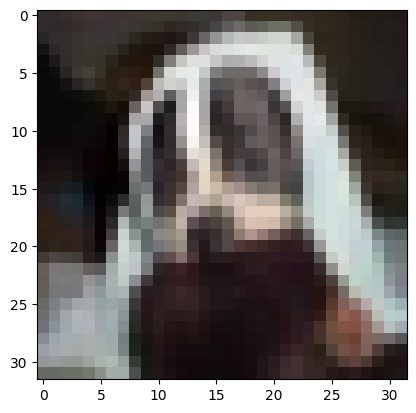

In [18]:
# Taking an Test Image 1
test_image1 = test_data[4143][0]
# Unnormalize the image
test_image1 = test_image1 * 0.5 + 0.5
plt.imshow(test_image1.permute(1, 2, 0))

In [19]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output = model(test_image1.view(1, 3, 32, 32))

# Check the new prediction
classes[output.argmax()]

'dog'

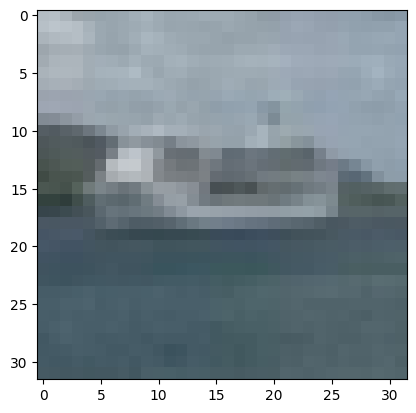

In [20]:
# Taking an Test Image 2
test_image1 = test_data[3331][0]
# Unnormalize the image
test_image1 = test_image1 * 0.5 + 0.5
plt.imshow(test_image1.permute(1, 2, 0))

In [21]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output = model(test_image1.view(1, 3, 32, 32))

# Check the new prediction
classes[output.argmax()]

'ship'

In [22]:
torch.save(model.state_dict(), "model_cifar_10.pth")
print("✅ Model saved as model_cifar_10.pth")

✅ Model saved as model_cifar_10.pth
